In [4]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import numpy as np
import pandas as pd
import io
import seaborn as sns
import math
import pprint
from umap import UMAP
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import umap
from hdbscan import HDBSCAN 
from googletrans import Translator
from sentence_transformers import SentenceTransformer
import pprint
from googletrans import Translator
translator = Translator()

In [11]:
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
import zstandard
from bertopic.representation import MaximalMarginalRelevance
import pathlib
import os
import ujson as json
import pandas as pd
from dateutil.relativedelta import relativedelta
from nltk import ngrams
import re
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy 
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import calendar
import stanza
import spacy_stanza
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\admin-
[nltk_data]     jalexander50\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the dataset

In [ ]:
df = pd.read_csv("cleaned_combined_telegram_data.csv")
df['post_date'] = pd.to_datetime(df['post_date'])

df = df[df['processed_message'].notnull()]
df.reset_index(drop=True, inplace=True)

### Using BERTopic Model (includes UMAP, HDBScan and c-tfidf) for the Topic Modeling 

In [52]:
def compute_coherence_values(start, limit, processed_message_cleaned):
    coherence_values = []
    
    representation_model = MaximalMarginalRelevance(diversity=0.8)
    umap_models = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=101)

    sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
    

    for n_topics in range(start, limit):
        topic_model = BERTopic(umap_model=umap_models,  
                               calculate_probabilities=False, 
                               embedding_model=sentence_model,
                               nr_topics = n_topics)
        
        docs = processed_message_cleaned.tolist()
        
        topics, probabilities = topic_model.fit_transform(processed_message_cleaned)

        # Preprocess Documents
        documents = pd.DataFrame({"Document": docs,
                                "ID": range(len(docs)),
                                "Topic": topics})

        documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

        # Extract vectorizer and analyzer from BERTopic
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()

        # Extract features for Topic Coherence evaluation
        words = vectorizer.get_feature_names_out()
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]

        topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                     for topic in range(len(set(topics))-1)]

        coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus,
                                       dictionary=dictionary, coherence='c_v')
        
        print(f"appending coherence {n_topics}")
        score = coherence_model.get_coherence()
        coherence_values.append(score)

        print(f"topic {n_topics} scores calculated, coherence score: {score}")

    return coherence_values

### February 24 to March 30 — Full Invasion

In [119]:
df_1 = df[["processed_message", "post_date"]]
full_invasion = df_1[(df_1["post_date"] >= datetime(2022, 2, 24)) & (df_1["post_date"] <= datetime(2022, 3, 30))]
full_invasion.reset_index(drop=True, inplace=True)

In [120]:
coherence_values = compute_coherence_values(2, 21, full_invasion["processed_message"])

appending coherence 2
topic 2 scores calculated, coherence score: 0.3611767716298175
appending coherence 3
topic 3 scores calculated, coherence score: 0.5882361230619575
appending coherence 4
topic 4 scores calculated, coherence score: 0.5930070092991939
appending coherence 5
topic 5 scores calculated, coherence score: 0.6219697780485891
appending coherence 6
topic 6 scores calculated, coherence score: 0.6414728064681974
appending coherence 7
topic 7 scores calculated, coherence score: 0.6192448603450414
appending coherence 8
topic 8 scores calculated, coherence score: 0.6214679322585123
appending coherence 9
topic 9 scores calculated, coherence score: 0.6231070276687299
appending coherence 10
topic 10 scores calculated, coherence score: 0.6184503417199404
appending coherence 11
topic 11 scores calculated, coherence score: 0.6081849483819356
appending coherence 12
topic 12 scores calculated, coherence score: 0.6120867626438338
appending coherence 13
topic 13 scores calculated, coherenc

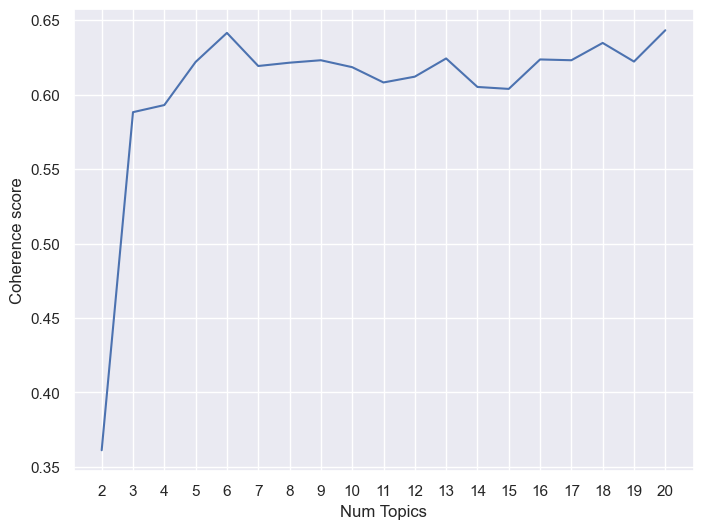

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
limit=21; start=2; step=1;
x = range(start, limit, step)
sns.set(color_codes=True)
sns.lineplot(x= x, y=coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
x_list = range(math.floor(min(x)), math.ceil(max(x))+1)
plt.xticks(x_list);

In [122]:
representation_model = MaximalMarginalRelevance(diversity=0.8)
umap_models = UMAP(n_neighbors=15, 
              n_components=5, 
              min_dist=0.0, 
              metric='cosine', 
              random_state=101)

sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

topic_model = BERTopic(umap_model=umap_models,  
                       calculate_probabilities=False, 
                       embedding_model=sentence_model,
                       nr_topics = 20)

topics, probabilities = topic_model.fit_transform(full_invasion["processed_message"])

In [124]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,10436,-1_украина_россия_всу_военный
1,0,7709,0_украина_россия_российский_военный
2,1,597,1_газ_цена_рубль_европа
3,2,413,2_нацист_азов_нацистский_мариуполь
4,3,406,3_зеленский_зеленского_украина_президент
5,4,214,4_биологический_сша_лаборатория_украина
6,5,167,5_китай_китайский_кнр_сша
7,6,164,6_беженец_польша_венгрия_югославия
8,7,133,7_видео_youtube_канал_заблокировать
9,8,101,8_facebook_meta_instagram_соцсеть


In [125]:
n_topics = 20
for n in range(n_topics-1):
    print(f"===================Topic {n}===================")
    for word in topic_model.get_topic(n):
        # print(word[0])
        try:
            eng = translator.translate(word[0], src='ru', dest='en')
            print(word[0], eng.text, word[1])
        except:
            pass
    print()

===================Topic 0===================
украина Ukraine 0.021632188910747197
россия Russia 0.018330547739058133
российский Russian 0.015865705381119605
военный military 0.014714795601675245
рф rf 0.013764725555234465
всу vsu 0.013589067522001605
город city 0.013115913303041548
киев Kyiv 0.011337511913969084
район area 0.01042046825036994
днр dnr 0.00995435654557696

===================Topic 1===================
газ gas 0.06370909201151727
цена price 0.039624927794839754
рубль ruble 0.034868102630204505
европа Europe 0.03366022795115606
россия Russia 0.030956043446594025
нефть oil 0.0278571606664948
российский Russian 0.026609791515042846
банк bank 0.024582424526027845
валюта currency 0.02366930387472246
поставка supply 0.02272818584032257

===================Topic 2===================
нацист Nazi 0.09920079406136541
азов basics 0.035953286731020384
нацистский Nazi 0.033057464646128264
мариуполь Mariupol 0.025247891600809064
украина Ukraine 0.021563464074936516
город city 0.021505

In [126]:
topics_over_time = topic_model.topics_over_time(full_invasion["processed_message"], 
                                                full_invasion["post_date"], 
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=15)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

### April 1 to May 11 — Western Boost


In [127]:
df_1 = df[["processed_message", "post_date"]]
western_boost = df_1[(df_1["post_date"] >= datetime(2022, 4, 1)) & (df_1["post_date"] <= datetime(2022, 5, 15))]
western_boost.reset_index(drop=True, inplace=True)

In [128]:
coherence_values = compute_coherence_values(2, 21, western_boost["processed_message"])

appending coherence 2
topic 2 scores calculated, coherence score: 0.41073551514102535
appending coherence 3
topic 3 scores calculated, coherence score: 0.5314804805709511
appending coherence 4
topic 4 scores calculated, coherence score: 0.6011337523110339
appending coherence 5
topic 5 scores calculated, coherence score: 0.6143378114108025
appending coherence 6
topic 6 scores calculated, coherence score: 0.6214089860247825
appending coherence 7
topic 7 scores calculated, coherence score: 0.6010263096896408
appending coherence 8
topic 8 scores calculated, coherence score: 0.6115341056146378
appending coherence 9
topic 9 scores calculated, coherence score: 0.6090203861075497
appending coherence 10
topic 10 scores calculated, coherence score: 0.6138525943665247
appending coherence 11
topic 11 scores calculated, coherence score: 0.6216334425713556
appending coherence 12
topic 12 scores calculated, coherence score: 0.6437838930808332
appending coherence 13
topic 13 scores calculated, coheren

In [129]:
representation_model = MaximalMarginalRelevance(diversity=0.8)
umap_models = UMAP(n_neighbors=15, 
              n_components=5, 
              min_dist=0.0, 
              metric='cosine', 
              random_state=101)

sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

topic_model = BERTopic(umap_model=umap_models,  
                       calculate_probabilities=False, 
                       embedding_model=sentence_model,
                       nr_topics = 20)

topics, probabilities = topic_model.fit_transform(western_boost["processed_message"])

In [130]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,8123,-1_украина_всу_россия_военный
1,0,5704,0_украина_военный_россия_район
2,1,339,1_газ_нефть_российский_цена
3,2,325,2_нацист_германия_нацизм_украина
4,3,254,3_инфляция_рост_санкция_экономика
5,4,97,4_минобороны_russia_россия_украина
6,5,96,5_финляндия_швеция_нато_вступление
7,6,74,6_медведчука_медведчук_обменять_обмен
8,7,71,7_китай_сша_китайский_тайвань
9,8,70,8_коронавирус_заболеть_выявить_сутки


In [131]:
n_topics = 20
for n in range(n_topics-1):
    print(f"===================Topic {n}===================")
    for word in topic_model.get_topic(n):
        # print(word[0])
        try:
            eng = translator.translate(word[0], src='ru', dest='en')
            print(word[0], eng.text, word[1])
        except:
            pass
    print()

===================Topic 0===================
украина Ukraine 0.01960179238290467
военный military 0.018556454227805785
россия Russia 0.017129472981615615
район area 0.014935906209042693
российский Russian 0.013627500940716356
всу vsu 0.013395031028916583
пункт paragraph 0.012038676827253535
область region 0.011096321708252664
уничтожить destroy 0.010928201279768363
сила force 0.010441763496873842

===================Topic 1===================
газ gas 0.12491103070166341
нефть oil 0.06262178927932747
российский Russian 0.04783260771417915
цена price 0.04332641641030063
поставка supply 0.042777218498334615
ес eu 0.035691111229523675
рубль ruble 0.033020395377687396
германия Germany 0.03221689623293514
санкция sanction 0.030786782936384136
евро Euro 0.029422489714719616

===================Topic 2===================
нацист Nazi 0.059830831527521694
германия Germany 0.042840072162303615
нацизм Nazism 0.031976902441648816
украина Ukraine 0.03076621769511892
азов basics 0.026785275122680915

### June 1 to July 31  — Stalemate


In [132]:
stalemate = df_1[(df_1["post_date"] >= datetime(2022, 6, 1)) & (df_1["post_date"] <= datetime(2022, 7, 31))]
stalemate.reset_index(drop=True, inplace=True)

In [134]:
coherence_values = compute_coherence_values(2, 20, stalemate["processed_message"])

appending coherence 2
topic 2 scores calculated, coherence score: 0.476082520539152
appending coherence 3
topic 3 scores calculated, coherence score: 0.7211420020197433
appending coherence 4
topic 4 scores calculated, coherence score: 0.6528814218137314
appending coherence 5
topic 5 scores calculated, coherence score: 0.7237632665313308
appending coherence 6
topic 6 scores calculated, coherence score: 0.7742248424832509
appending coherence 7
topic 7 scores calculated, coherence score: 0.7798467158489669
appending coherence 8
topic 8 scores calculated, coherence score: 0.7578206768253487
appending coherence 9
topic 9 scores calculated, coherence score: 0.7571880418647767
appending coherence 10
topic 10 scores calculated, coherence score: 0.7610497048705007
appending coherence 11
topic 11 scores calculated, coherence score: 0.7493768682239393
appending coherence 12
topic 12 scores calculated, coherence score: 0.7442243678365172
appending coherence 13
topic 13 scores calculated, coherence

### October 8 to December — Russia’s Escalation


In [93]:
russia_esc = df_1[(df_1["post_date"] >= datetime(2022, 10, 8)) & (df_1["post_date"] <= datetime(2022, 12, 31))]
russia_esc.reset_index(drop=True, inplace=True)

In [100]:
coherence_values = compute_coherence_values(2, 16, russia_esc["processed_message"])

appending coherence 2
topic 2 scores calculated, coherence score: 0.4723311576975295
appending coherence 3
topic 3 scores calculated, coherence score: 0.5788873079454011
appending coherence 4
topic 4 scores calculated, coherence score: 0.5840534423819771
appending coherence 5
topic 5 scores calculated, coherence score: 0.644517942547779
appending coherence 6
topic 6 scores calculated, coherence score: 0.6641186503356138
appending coherence 7
topic 7 scores calculated, coherence score: 0.6615526819734802
appending coherence 8
topic 8 scores calculated, coherence score: 0.6857275004508766
appending coherence 9
topic 9 scores calculated, coherence score: 0.66408708511045
appending coherence 10
topic 10 scores calculated, coherence score: 0.6621660572184154
appending coherence 11
topic 11 scores calculated, coherence score: 0.6864160164705979
appending coherence 12
topic 12 scores calculated, coherence score: 0.7069582172060831
appending coherence 13
topic 13 scores calculated, coherence s

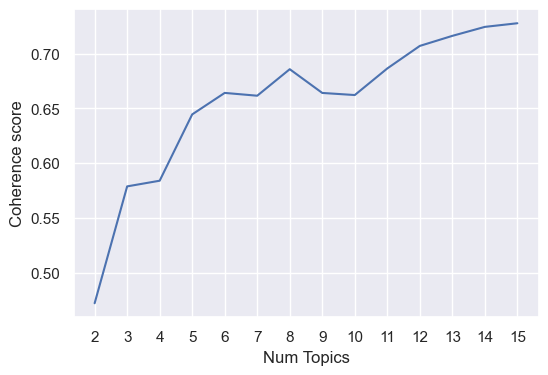

In [101]:
fig, ax = plt.subplots(figsize=(6, 4))
limit=16; start=2; step=1;
x = range(start, limit, step)
sns.set(color_codes=True)
sns.lineplot(x= x, y=coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
x_list = range(math.floor(min(x)), math.ceil(max(x))+1)
plt.xticks(x_list);

In [102]:
representation_model = MaximalMarginalRelevance(diversity=0.8)
umap_models = UMAP(n_neighbors=15, 
              n_components=5, 
              min_dist=0.0, 
              metric='cosine', 
              random_state=101)

sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

topic_model = BERTopic(umap_model=umap_models,  
                       calculate_probabilities=False, 
                       embedding_model=sentence_model,
                       nr_topics = 15)

topics, probabilities = topic_model.fit_transform(russia_esc["processed_message"])

In [104]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,10425,-1_россия_украина_всу_военный
1,0,8561,0_украина_россия_район_всу
2,1,310,1_турция_иран_армения_турецкий
3,2,281,2_цена_инфляция_нефть_рост
4,3,268,3_польша_белоруссия_ракета_польский
5,4,175,4_китай_китайский_си_тайвань
6,5,135,5_молдавия_сербия_косово_серб
7,6,85,6_европарламент_европа_европейский_евросоюз
8,7,83,7_православный_церковь_папа_упц
9,8,59,8_лайф_погода_зима_ледяной


In [103]:
n_topics = 15
for n in range(n_topics-1):
    print(f"===================Topic {n}===================")
    for word in topic_model.get_topic(n):
        # print(word[0])
        try:
            eng = translator.translate(word[0], src='ru', dest='en')
            print(word[0], eng.text, word[1])
        except:
            pass
    print()

===================Topic 0===================
украина Ukraine 0.018178475863693557
россия Russia 0.015633031143121777
район area 0.015170110052245618
всу vsu 0.015018733589100497
российский Russian 0.014258907459546303
направление direction 0.013934376157870583
область region 0.013393790734469677
удар hit 0.01266628090576077
военный military 0.011849436750307404
войско army 0.011273779018651385

===================Topic 1===================
турция Türkiye 0.08929077842808102
иран Iran 0.05474799625353606
армения Armenia 0.03723708511928809
турецкий Turkish 0.034063652663073915
эрдоган erdogan 0.034058337462375576
россия Russia 0.02992585769969423
израиль Israel 0.029516394642161842
азербайджан Azerbaijan 0.028640900112975813
сирия Syria 0.02441905915512177
иранский Iranian 0.019507426128149725

===================Topic 2===================
цена price 0.08798016796324251
инфляция inflation 0.07571614793082145
нефть oil 0.06512089673005636
рост height 0.06257489764398046
потолок ceiling 

In [105]:
topics_over_time = topic_model.topics_over_time(russia_esc["processed_message"], 
                                                russia_esc["post_date"], 
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=15)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=13)